# Introduction

This notebook contains analysis for high-throughput CRISPR off-target profiling experiment. The details of the protocol are described in our Bioarxiv preprint, available here https://www.biorxiv.org/content/early/2018/04/16/190603. A very brief summary of the experimental design is added here to help the reader understand this notebook.

> We designed an in vitro library-based assay to assess binding mismatch tolerances and the effects of sequence variation outside the Cas13a:crRNA binding site. To distinguish between weak crRNA-dependent target binding and crRNA-independent nonspecific binding, our experimental design included two different sequence libraries that were mutagenized in the same manner. Only one crRNA was used in any given binding experiment, allowing us to use the non-complementary target as a reference point for nonspecific binding. The libraries were mixed and incubated separately with two concentrations of biotinylated Lbu-dCas13a protein complexed with crRNA. After incubation, bound RNAs were eluted and subjected to Illumina-based sequencing . Controls were conducted to determine input library distribution and the effect of non-specific Cas13a background binding. 

To use this notebook, first deduplicate and count the raw sequencing reads using the script "DeduplicateMultipleTargets.py" in this Github repo. A script to run this on a batch of data is also available in the same repo. The dedupe script will produce two gzipped tab-delimited text output files: "reads_counts.txt.gz" and "umi_counts.txt.gz". This notebook requires these files as input.

In [2]:
import numpy as np
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import json
import gzip
import os
import pandas as pd

## Declare constants, name variables

- Note that the target RNAs were originally called L3 and L4 (as their sequences were derived from loci in the Lambda phage genome). This naming also appears in the SRA submission for these data. In the final version of the manuscript these RNAs have been renamed to RNA_Y and RNA_X respectively. 

In [3]:
MIN_COUNTS = 10
MAX_MM = 4
REPS = [0, 1, 2]
TARGETS = ['L3', 'L4']

target_to_color = {'L3' : 'b', 'L4' : 'r'}
rep_to_marker = {0 : 'o', 1 : 'v', 2 : 's'}
update_label = lambda s: s.replace('L4', 'RNA_X').replace('L3', 'RNA_Y')

samples = {
    '10nM_L3'  : ['sample_1', 'sample_2', 'sample_3'],
    '100nM_L3' : ['sample_4', 'sample_5', 'sample_6'],
    '10nM_L4'  : ['sample_7', 'sample_8', 'sample_9'],
    '100nM_L4' : ['sample_10', 'sample_11', 'sample_12'],
    'apo'      : ['sample_13', 'sample_14', 'sample_15'],
    'input'    : ['sample_16', 'sample_17', 'sample_18']}

#reverse the dict so it is sample -> identifier
samples_rev = {}
for (key, lst) in samples.items():
    for i in lst:
        samples_rev[i] = key

## Read deduplicated counts file and store as pandas dataframe

- These methods read the output files from the script DeduplicateMultipleTargets.py
- Each sample file has two outputs- *read_counts.txt.g, and *umi_counts.txt.gz
- Files are tab delimited
- The read counts file has the format
-- Sequence \t Counts \t Target \t Num_mismatches \t Mismatch_positions
-- CTGGTTAACTTCCGAAATTGCGGGTC	1	L3	4	5,15,17,25
- These methods also aggregate replicates, get average counts etc

In [4]:
def read_single_expt_data(fname, counts_metadata = None):
    counts = {}
    if counts_metadata is None:
        counts_metadata = {}
    
    with gzip.open(fname, 'r') as inf:
        header = inf.readline()
        for line in inf:
            try:
                (kmer, count, ref_id, num_mismatches, mismatch_str) = \
                    line.decode('utf-8').strip().split('\t')
                mismatch_lst = [int(i) for i in mismatch_str.split(',')]
            except ValueError:
                (kmer, count, ref_id, num_mismatches) = \
                    line.decode('utf-8').strip().split('\t')
                mismatch_lst = []
            num_mismatches = int(num_mismatches)
            
            count = int(count)
            if count >= MIN_COUNTS and num_mismatches <= MAX_MM:
                counts[kmer] = int(count)
                if kmer not in counts_metadata:
                    counts_metadata[kmer] = {
                        'ref_id' : ref_id, 
                        'num_mismatches' : num_mismatches,
                        'mismatch_lst' : mismatch_lst,
                        'kmer' : kmer}
    return counts, counts_metadata
            
def read_complete_expt_data(data_dir):
    counts_metadata = {}
    counts = {}
    
    for fname in os.listdir(data_dir):
        if fname.endswith('read_counts.txt.gz'):
            print('Working on file %s' % fname)
            file_counts, counts_metadata = read_single_expt_data(
                data_dir + fname, counts_metadata = counts_metadata)
            counts[fname.replace('_read_counts.txt.gz', '')] = file_counts
    return counts, counts_metadata

def combine_reps(counts, samples):
    samples_ = {}
    for sample, reps in samples.items():
        key = sample + '_averaged'
        r1, r2, r3 = reps
        counts[key] = counts.apply(lambda row : (row[r1] + row[r2] + row[r3]) / 3, axis=1)
        samples_[key] = []
        samples_[key].append(key)
    return counts, samples_

def update_mismatch_span(counts_metadata):
    counts_metadata['mismatch_span'] = \
        counts_metadata.apply(
            lambda row: 
                row['mismatch_lst'][-1] - row['mismatch_lst'][0] if len(row['mismatch_lst']) >= 2 else 0,
            axis = 1)
    return counts_metadata

In [5]:
counts_dict, counts_metadata_dict = read_complete_expt_data('./')

counts = pd.DataFrame(counts_dict)
#clean up data. 
#1. set NA values to 0
#2. convert raw counts to relative abundance
#3. add column for averaged data in each condition
counts = counts.fillna(0)
counts = counts / counts.sum(axis = 0)
counts, samples_combined = combine_reps(counts, samples)

#annotate dataframe with metadata for each kmer
counts_metadata = pd.DataFrame(counts_metadata_dict)
counts_metadata = counts_metadata.transpose()
counts_metadata = update_mismatch_span(counts_metadata)

data = pd.merge(counts, counts_metadata, left_index = True, right_index = True)

Working on file sample_10_read_counts.txt.gz
Working on file sample_11_read_counts.txt.gz
Working on file sample_12_read_counts.txt.gz
Working on file sample_13_read_counts.txt.gz
Working on file sample_14_read_counts.txt.gz
Working on file sample_15_read_counts.txt.gz
Working on file sample_16_read_counts.txt.gz
Working on file sample_17_read_counts.txt.gz
Working on file sample_18_read_counts.txt.gz
Working on file sample_1_read_counts.txt.gz
Working on file sample_2_read_counts.txt.gz
Working on file sample_3_read_counts.txt.gz
Working on file sample_4_read_counts.txt.gz
Working on file sample_5_read_counts.txt.gz
Working on file sample_6_read_counts.txt.gz
Working on file sample_7_read_counts.txt.gz
Working on file sample_8_read_counts.txt.gz
Working on file sample_9_read_counts.txt.gz


In [6]:
#visually inspect data
data[0:5]

,sample_1,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,...,10nM_L4_averaged,apo_averaged,10nM_L3_averaged,input_averaged,100nM_L3_averaged,kmer,mismatch_lst,num_mismatches,ref_id,mismatch_span
AAAATAACCTGGTGGTTCAGGCGGCG,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000004,0.000000,...,0.000000,0.000000,0.0,0.000001,0.0,AAAATAACCTGGTGGTTCAGGCGGCG,"[0, 2, 6]",3,L4,6
AAAATAGACTGGTGGTTCAGGCGGCG,0.0,0.000007,0.000005,0.000006,0.000006,0.0,0.0,0.0,0.000004,0.000005,...,0.000006,0.000002,0.0,0.000003,0.0,AAAATAGACTGGTGGTTCAGGCGGCG,"[0, 2, 7]",3,L4,7
AAAATAGCATGGTGGTTCAGGCGGCG,0.0,0.000005,0.000006,0.000000,0.000005,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000002,0.0,0.000000,0.0,AAAATAGCATGGTGGTTCAGGCGGCG,"[0, 2, 8]",3,L4,8
AAAATAGCCGGGTGGTTCAGGCGGCG,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000002,0.000000,0.0,0.000000,0.0,AAAATAGCCGGGTGGTTCAGGCGGCG,"[0, 2, 9]",3,L4,9
AAAATAGCCTGGTGGTTAAGGCGGCG,0.0,0.000006,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000004,0.000000,...,0.000000,0.000000,0.0,0.000001,0.0,AAAATAGCCTGGTGGTTAAGGCGGCG,"[0, 2, 17]",3,L4,17


## Plot inter-replicate comparisons
- Each point represents the relative abundance of a kmer in a pair of samples
- Plot on log / log axis
- Report Pearson R^2

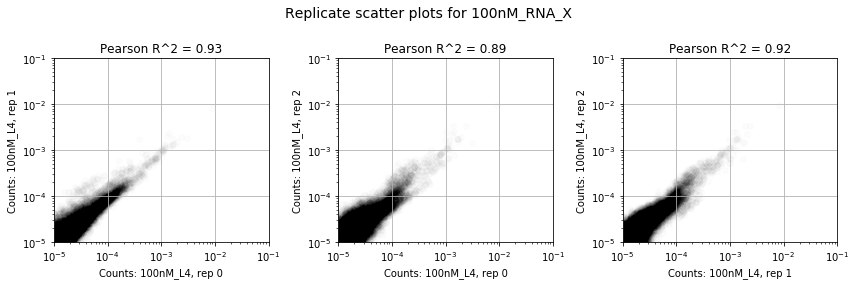

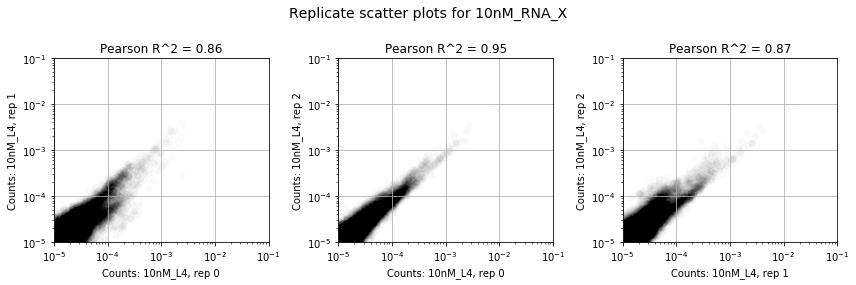

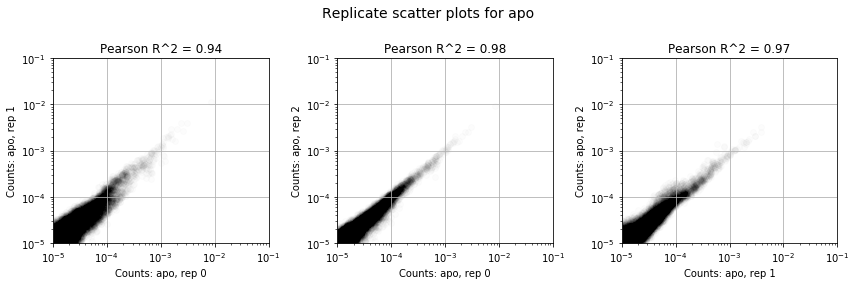

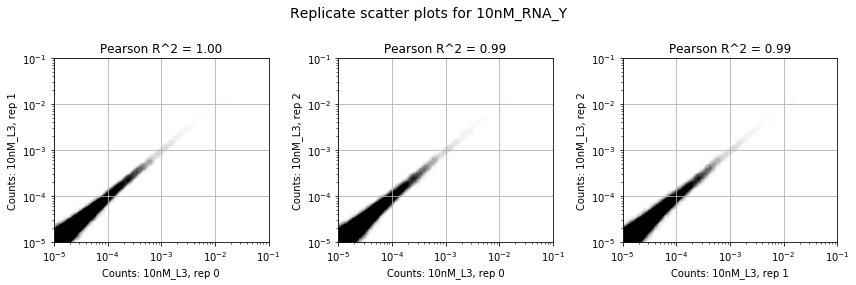

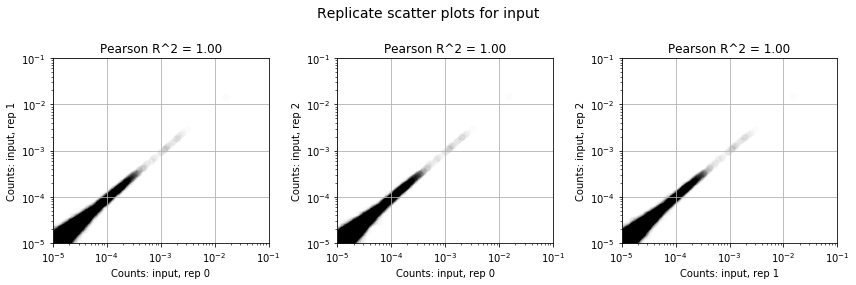

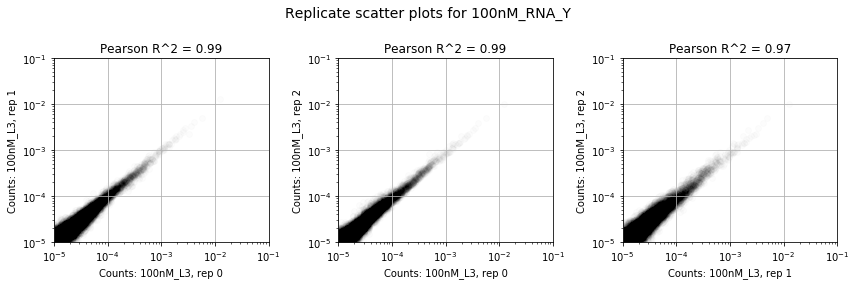

In [7]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def plot_replicates_scatter(expt, spearman = False):
    fig, ax_arr = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
    
    for k, (i, j) in enumerate(itertools.combinations(REPS, 2)):        
        ax = ax_arr[k]
        
        s1 = samples[expt][i]
        s2 = samples[expt][j]
        x = []
        y = []
        
        for x_, y_ in zip(data[s1].as_matrix(), data[s2].as_matrix()):
            if x_ > 0 and y_ > 0:
                x.append(x_)
                y.append(y_)
        
        if spearman:
            r, pval = spearmanr(x, y)
        else:
            r, pval = pearsonr(x, y)
        
        ax.scatter(x, y, alpha = 0.01, color = 'k')
        
        
        ax.set_xlabel('Counts: %s, rep %i' % (expt, i))
        ax.set_ylabel('Counts: %s, rep %i' % (expt, j))
        ax.grid()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([10**-5, 10**-1])
        ax.set_ylim([10**-5, 10**-1])
        
        if spearman:
            title = '%s R^2 = %0.00002f' % ('Spearman', r**2)
        else:
            title = '%s R^2 = %0.00002f' % ('Pearson', r**2)
            
        #print(r**2)
        ax.set_title(title)
        
    fig.suptitle('Replicate scatter plots for %s' % update_label(expt), size = 14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
        
for sample in samples.keys():
    plot_replicates_scatter(sample)

## Plot number of mismatches per target library

- X axis: number of mismatches
- Y axis: relative abundance
- Color: target library (RNA_X or RNA_Y)

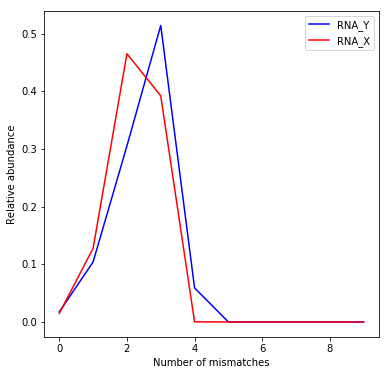

In [8]:
def plot_mismatch_count(expt):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
    
    for target in TARGETS:
        y = [0] * 10
        abundances = data.loc[data['ref_id'] == target][expt].as_matrix()
        mismatches = data.loc[data['ref_id'] == target]['num_mismatches'].as_matrix()
        
        for x_, y_ in zip(mismatches, abundances):
            y[x_] += y_
        x = list(range(10))
        y /= np.sum(y)
        ax.plot(x, y, color = target_to_color[target], label = update_label(target))
    ax.legend()
    ax.set_xlabel('Number of mismatches')
    ax.set_ylabel('Relative abundance')
    
    fig.savefig('./plots/mm_dist.pdf')
    
plot_mismatch_count('input_averaged')

## Methods to normalize / regularize the data

- Fold-change values in each experiment is regularized by subtracting a constant A, and rescaling by a constant B
-- FC_regularized = (FC_raw - A) / B
- The constants A and B are caclulated directly from the data
-- A is the average fold-change for the off-target library (ie if using guide X, off-target library is Y)
-- B is the average fold-change for the on-target library
- The reasoning behind this regularization is described in detail in the methods section of our preprint

In [11]:
def get_wt_fc(expt, ctrl, target):
    wt_ctrl = data.loc[data['num_mismatches'] == 0].loc[data['ref_id'] == target][ctrl].as_matrix()
    wt_expt = data.loc[data['num_mismatches'] == 0].loc[data['ref_id'] == target][expt].as_matrix() 
    return wt_expt / wt_ctrl

def get_average_fc(expt, ctrl, target):
    fc_ctrl = np.mean(data.loc[data['ref_id'] == target][ctrl].as_matrix())
    fc_expt = np.mean(data.loc[data['ref_id'] == target][expt].as_matrix())
    return fc_expt / fc_ctrl

def normalize_datapoint(y, offset, rescale):
    return (y - offset) / rescale

def get_other_target(t = 'L3'):
    return list(set(TARGETS) - set([t]))[0]

def get_normalized_fc(expt, ctrl, on):
    fold_change = {}
    
    off = get_other_target(on)
    offset = get_average_fc(samples_combined[expt], samples_combined[ctrl], off)
    rescale = get_average_fc(samples_combined[expt], samples_combined[ctrl], on)
    
    for target in TARGETS:
        ctrl_data = data.loc[data['ref_id'] == target][ctrl].as_matrix()
        expt_data = data.loc[data['ref_id'] == target][expt].as_matrix()
        
        fold_change[target] = []
        for e, c in zip(expt_data, ctrl_data):
            if e > 0 and c > 0:
                fold_change[target].append( ((e / c) - offset) / rescale)
            else:
                fold_change[target].append(None)
    return fold_change

def get_fcs(expt, ctrl):
    fc_lst = {}
    for target in TARGETS:
        numerator = data.loc[data['ref_id'] == target][expt].as_matrix()
        denominator = data.loc[data['ref_id'] == target][ctrl].as_matrix()
        fc_lst[target] = []
        
        for (a,b) in zip(numerator, denominator):
            if a > 0 and b > 0:
                fc_lst[target].append(a/b)
    return fc_lst

## Plot fold-change histograms for averaged datasets
- Fold change is calculated relative to APO sample (see next codeblock for justification)
- Show as a histogram or violin plot, separately fo each target
- This is to show that the raw, non-normalized data still shows enrichment

In [15]:
"""
plot fc histograms for each target in each sample
"""
import math
import scipy as sp

    
def plot_normed_fc_hist(expt, ctrl, on = 'L3', normed = True):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4))
    bins = np.arange(-1, 4, 0.1)
    
    if normed:
        fcs_dict = get_normalized_fc(expt, ctrl, on = on)
    else:
        fcs_dict = get_fcs(expt, ctrl)
        
    for x, target in enumerate(reversed(TARGETS)):
        fcs = [val for val in fcs_dict[target] if val is not None]
        #print(fcs)
        mean = np.mean(fcs)
        stdev = np.std(fcs)
        ax.violinplot(fcs, [x], points=100, widths=0.75, showmeans=True, showextrema=False)

    ax.set_xlabel('Target')
    ax.set_ylabel('Regularized fold change')
    ax.set_title('Fold change violin plot:\n %s' % (update_label(expt)))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['RNA_X', 'RNA_Y'])
    ax.set_ylim([-1, 6])
    ax.grid()
    
    rna_x = [val for val in fcs_dict['L3'] if val is not None]
    rna_y = [val for val in fcs_dict['L4'] if val is not None]

    pval = sp.stats.ttest_ind(rna_x, rna_y, equal_var = False)
    print(pval)
    
    #fig.savefig('./plots/rebuttal/violin_plots_%s_%s__NoNorm.pdf' % (update_label(expt), update_label(ctrl)))

Ttest_indResult(statistic=125.0338365810328, pvalue=0.0)
Ttest_indResult(statistic=191.30206629476407, pvalue=0.0)
Ttest_indResult(statistic=-86.44736862861505, pvalue=0.0)
Ttest_indResult(statistic=-118.00941422584965, pvalue=0.0)


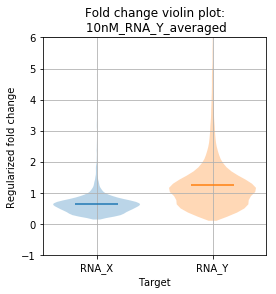

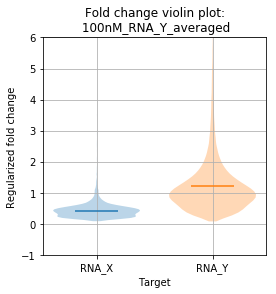

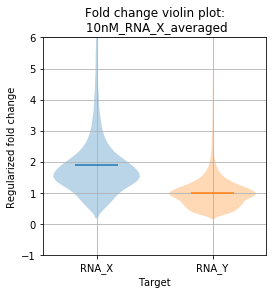

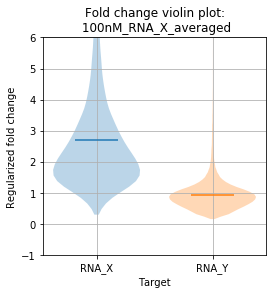

In [16]:
#plot violin plots against apo, without normalizing

plot_normed_fc_hist(    
    '10nM_L3_averaged', 
    'apo_averaged',
    on = 'L3', 
    normed = False)

plot_normed_fc_hist(    
    '100nM_L3_averaged', 
    'apo_averaged',
    on = 'L3',
    normed = False)
plot_normed_fc_hist(    
    '10nM_L4_averaged', 
    'apo_averaged',
    on = 'L4',
    normed = False)
plot_normed_fc_hist(    
    '100nM_L4_averaged', 
    'apo_averaged',
    on = 'L4',
    normed = False)


Ttest_indResult(statistic=60.98780918068868, pvalue=0.0)
Ttest_indResult(statistic=114.07584295536304, pvalue=0.0)
Ttest_indResult(statistic=-40.49307881399904, pvalue=0.0)
Ttest_indResult(statistic=-84.07794888966357, pvalue=0.0)


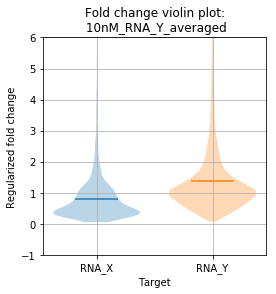

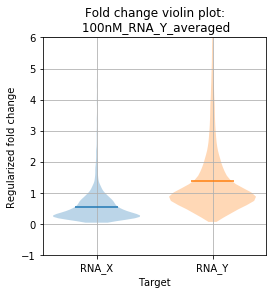

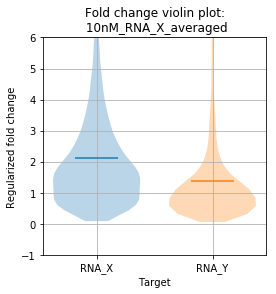

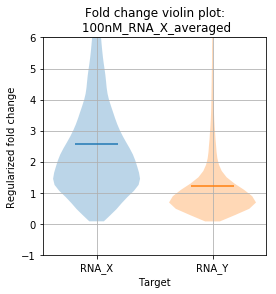

In [17]:
# Do the same thing against input, without normalizing 

plot_normed_fc_hist(    
    '10nM_L3_averaged', 
    'input_averaged',
    on = 'L3',
    normed = False)
plot_normed_fc_hist(    
    '100nM_L3_averaged', 
    'input_averaged',
    on = 'L3',
    normed = False)
plot_normed_fc_hist(    
    '10nM_L4_averaged', 
    'input_averaged',
    on = 'L4',
    normed = False)
plot_normed_fc_hist(    
    '100nM_L4_averaged', 
    'input_averaged',
    on = 'L4',
    normed = False)

## Plot orthogonality between guides
- The purpose of this plot is to isolate guide- dependent signal
- Scatter plot of fold-changes
- Requires 3 samples: one reference (R), and two experimental conditions (A, B)
    - Experimental conditions should be same protein concentration, different guide sequence
    - Reference sample is a control-- either input library, or apo (no-guide) protein
- X- axis is fold change (A/R), Y- axis is fold change (B/R)
- Points are color-coded based on which target they originate from
- This analysis shows that when comparing +guide samples to the apo condition, the fold change signal behaves as expected
    - Orthogonality of the colors: targets with high fold change with L3 guide have low fold change with L4 (and inverse)
    - Running the same comparison with the input sample as Refernce shows a less clear signal
    - Indicates that apo protein has a non-negligable background binding sequence preferences

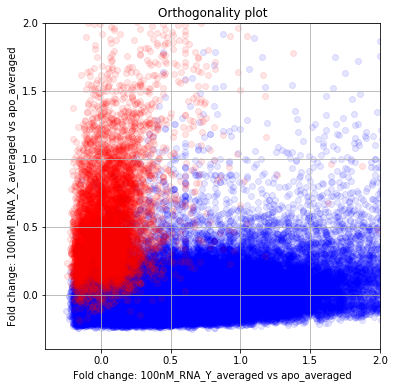

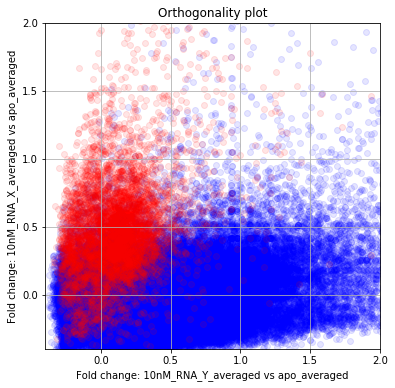

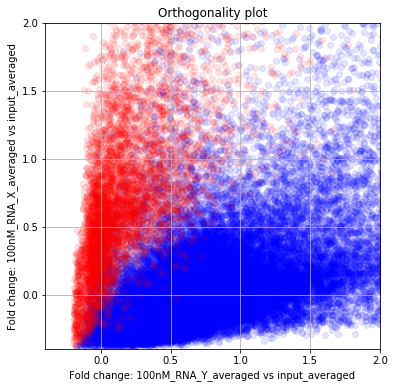

In [12]:
"""
orthogonality plot with replicates- > different markers

"""

def plot_orthogonality(expt_1, expt_2, ctrl = 'apo', combined = True):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))    
    
    if not combined:
        reps = REPS
    else:
        reps = [0]
    
    for rep in reps:
        expt_1_fc = get_normalized_fc(
            samples_combined[expt_1][rep], 
            samples_combined[ctrl][rep],
            'L3')
        
        expt_2_fc = get_normalized_fc(
            samples_combined[expt_2][rep], 
            samples_combined[ctrl][rep],
            'L4')
        
        for target in TARGETS:
            x = expt_1_fc[target]
            y = expt_2_fc[target]
            c = target_to_color[target]
            
            ax.scatter(
                x, y, color = c, 
                alpha = 0.1, marker = rep_to_marker[rep])
    ax.set_xlabel('Fold change: %s vs %s' % (update_label(expt_1), update_label(ctrl)))
    ax.set_ylabel('Fold change: %s vs %s' % (update_label(expt_2), update_label(ctrl)))
    ax.set_title('Orthogonality plot')
    ax.set_xlim([-0.4, 2])
    ax.set_ylim([-0.4, 2])
    ax.grid()
    
plot_orthogonality(
    '100nM_L3_averaged', 
    '100nM_L4_averaged', 
    'apo_averaged', 
    combined = True)

plot_orthogonality(
    '10nM_L3_averaged', 
    '10nM_L4_averaged', 
    'apo_averaged', 
    combined = True)

plot_orthogonality(
    '100nM_L3_averaged', 
    '100nM_L4_averaged',
    'input_averaged',
    combined = True)

## Permutation tests

- The purpose of these tests is to check whether an observed difference in fold-changes between the on- and off- target sequence is statistically significant
- The rationalization behind the tests is described here

> To calculate the statistical significance of these observations, we performed permutation tests. To do this, we drew a random sample of 9 points each from the two targets, and record the difference in the means between these two sub-samplings. We repeated this sampling process 100,000 times to produce an empirical distribution of the difference in means for the guide-complementary and guide-non-complementary sequences. This empirical distribution of subsampled fold changes was used to compute a p-value for observing a given difference in means

In [13]:
import bisect
np.random.seed(0) 

def get_permutation_tests(data_for_t_test):
    """
    permutation test
        permute the positions of red / blue dots separately
        draw a fixed number of samples from each 
        
    """
    
    pvals = []    
    n_permutations = 100000
    n_samples_per_permutation = 9
    
    permutation_data = {}
    for target, by_pos in data_for_t_test.items():
        permutation_data[target] = []
        for val in by_pos.values():
            permutation_data[target] += val
        
    test_means = lambda l3, l4: np.fabs(np.mean(l3) - np.mean(l4))
    
    diff = []
    for i in range(n_permutations):
        l3_subset = np.random.choice(permutation_data['L3'], size = n_samples_per_permutation)
        l4_subset = np.random.choice(permutation_data['L4'], size = n_samples_per_permutation)
        
        diff.append(test_means(l3_subset, l4_subset))
    diff = sorted(diff)
    
    for pos in sorted(list(data_for_t_test['L3'].keys())):
        try:
            l3_data = data_for_t_test['L3'][pos]
            l4_data = data_for_t_test['L4'][pos]
            diff_obs = test_means(l3_data, l4_data)
            p = bisect.bisect_left(diff, diff_obs)
            pvals.append(p / n_permutations)

        except KeyError:
            pass
        
    return pvals

In [14]:
def get_single_mm_data(expt_id, ctrl_id, on = 'L3'):
    NUM_MM = 1       
    off = get_other_target(on)
        
    rows = data.loc[data['num_mismatches'] == NUM_MM].loc[data['ref_id'] == on]
    ctrl_data = rows[ctrl_id].as_matrix()
    expt_data = rows[expt_id].as_matrix()
    kmer_data = rows['kmer'].as_matrix()
    y = expt_data / ctrl_data
    x = [i[0] for i in rows['mismatch_lst'].as_matrix()]
    nucs = []
    
    for kmer, x_ in zip(kmer_data, x):
        #print(kmer, x_, kmer[x_])
        nucs.append(kmer[x_])
    
    coords = [tup for tup in zip(x, y, nucs)]
    coords = sorted(coords, key = lambda tup: tup[0])
    return [tup[0] for tup in coords], [tup[1] for tup in coords], [tup[2] for tup in coords]


def get_pair_mm_data(expt_id, ctrl_id, on = 'L3'):
    NUM_MM = 2
    off = get_other_target(on)
    
    seq_len = len('AAAATAGCCGGGTGGTTCAGGCGGCG')
    WINDOW = seq_len
    
    expt_freq = np.zeros((seq_len, 4))
    ctrl_freq = np.zeros((seq_len, 4))    
    
    nucs = ['A', 'G', 'C', 'T']
    nucs_to_idx = {key : i for i, key in enumerate(nucs)}
    target_filter = data.loc[data['ref_id'] == on].loc[data['num_mismatches'] == 2]
    for _, row in target_filter.iterrows():
        mm_lst = row['mismatch_lst']
        if mm_lst[1] - mm_lst[0] < WINDOW:
            for pos in mm_lst:
                nuc = row['kmer'][pos]
                #print(pos, nuc, nucs_to_idx[nuc], row[expt])
                expt_freq[pos, nucs_to_idx[nuc]] += row[expt_id] / len(mm_lst)
                ctrl_freq[pos, nucs_to_idx[nuc]] += row[ctrl_id] / len(mm_lst)
    y = []
    x = []
    for i in range(seq_len):
        for j in range(4):
            if expt_freq[i,j] > 0 and ctrl_freq[i,j] > 0:
                y.append(expt_freq[i,j] / ctrl_freq[i,j])
                x.append(i)
    return x, y

def get_quad_mm_raster_data(expt_id, ctrl_id, on = 'L3'):
    NUM_MM = 4    
    off = get_other_target(on)
    
    y = []
    x = []
    
    rows = data.loc[data['num_mismatches'] == 4].loc[data['ref_id'] == 'L3']
    for _, row in rows.iterrows():
        mismatches = sorted(row['mismatch_lst'])
        if mismatches[0] == mismatches[1] - 1 == mismatches[2] - 2 == mismatches[3] - 3:
            try:
                y.append(row[expt_id].as_matrix() / row[ctrl_id].as_matrix())
                x.append(mismatches[0])
            except ZeroDivisionError:
                x.append(mismatches[0])
                y.append(0)
                
    coords = [tup for tup in zip(x, y)]
    coords = sorted(coords, key = lambda tup: tup[0])
    return [tup[0] for tup in coords], [tup[1] for tup in coords]





def plot_single_mm(expt, ctrl, pvals = None, key = 'single'):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,3))    
    
    on = expt.split('_')[1]
    off = (set(TARGETS) - set([on])).pop() 
    
    if expt.endswith('averaged'):
        combined = True
        wt_on = get_average_fc(expt, ctrl, on)
        wt_off = get_average_fc(expt, ctrl, off)
        reps = [0]
    else:
        combined = False
        reps = REPS 
        pvals = []
    
    
    wt_x = 27
    ax.axvline(wt_x - 1, color = 'k')
    data_for_t_test = {t : {} for t in TARGETS}
    
    
    nuc_to_marker = {
        'A' : 'o',
        'C' : 'v',
        'G' : 's',
        'T' : 'h'}
    
    for rep in reps:
        if combined:
            expt_sample = samples_combined[expt]
            ctrl_sample = samples_combined[ctrl]            
        else:
            expt_sample = samples[expt][rep]
            ctrl_sample = samples[ctrl][rep]
            
        offset = get_average_fc(expt_sample, ctrl_sample, off)
        rescale = get_average_fc(expt_sample, ctrl_sample, on)
        
        for target in TARGETS:
            
            if key == 'single':
                x, y, nuc = get_single_mm_data(expt_sample, ctrl_sample, on = target)
            elif key == 'pairs_all':
                x, y = get_pair_mm_data(expt_sample, ctrl_sample, on = target) 
                
            elif key == 'quad':
                x, y = get_quad_mm_raster_data(expt_sample, ctrl_sample, on = target)
            
            wt_y = get_wt_fc(expt_sample, ctrl_sample, target)
            y = [normalize_datapoint(i, offset, rescale) for i in y]
            
            if key == 'single':
                for x_, y_, nuc_ in zip(x, y, nuc):
                    ax.scatter(
                        x_, 
                        y_, 
                        color = target_to_color[target], 
                        marker = nuc_to_marker[nuc_])
            else:
                #print(len(x), len(y))
                for x_, y_ in zip(x, y):
                    #print(x_, y_)
                    ax.scatter(
                        x_, 
                        y_, 
                        color = target_to_color[target], 
                        marker = 'o')
            
            to_average = {}
            for (x_, y_) in zip(x, y):
                if x_ not in data_for_t_test[target]:
                    data_for_t_test[target][x_] = []
                data_for_t_test[target][x_].append(y_)
                if x_ not in to_average:
                    to_average[x_] = []
                to_average[x_].append(y_)
            
            averaged_x = list(sorted(to_average.keys()))
            averaged_y = [np.mean(to_average[x_]) for x_ in averaged_x]
            ax.plot(averaged_x, averaged_y, color = target_to_color[target], marker = None)
            
            ax.scatter(
                wt_x,
                normalize_datapoint(wt_y, offset, rescale),
                color = target_to_color[target], 
                marker = 'o',
                alpha = 0.25)
 
    if not combined:
        pvals = get_permutation_tests(data_for_t_test)
        #print(pvals)
    
    PVAL_CUTOFF = 0.05
    for i, p in enumerate(pvals):
        if not p > PVAL_CUTOFF:
            ax.fill_between([i - 0.5, i + 0.5], -5, 5, color = 'gray', alpha = 0.2)  
            
        
    ax.set_xlabel('Position of mismatch')
    ax.set_ylabel('Regularized fold-change')    
    ax.set_ylim([-0.4, 1.8])
        
    ax.set_title('Single-MM fold change\n%s vs %s' % (update_label(expt), update_label(ctrl)))
    ax.set_xlim([-1, wt_x + 1])
    ax.set_xticks(list(range(wt_x + 2)))
    
    xticklabels = ['FS', 'FS', 'FS'] + \
        [i for i in (range(1, 21))] + \
        ['FS', 'FS', 'FS'] + \
        [' ', '0 MM']
    ax.set_xticklabels(xticklabels, fontsize = 6)
    plt.tight_layout()
    #fig.savefig('./plots/rebuttal/singleMM_%s_vs_%s__PermutationMeanDifference.pdf' % \
    #            (update_label(expt), update_label(ctrl)))
    
    return pvals
        
    


## 1D mismatch vs position plots
- Scatter plot
    - X-axis is position along the guide
    - Y-axis is fold change (relative to apo protein sample)
- Each point represents a sequence with a single mismatch at a position determied by X
    - Color represents the target a sequence originates from
    - Line represents the median of all points for a given target
- For each X- value, there are multiple mismatches possible so there might be multiple points on the Y
- Shading shows statistical significance by a permutation test
    - Shaded areas show where the red and blue seqs are NOT statically separated from each other

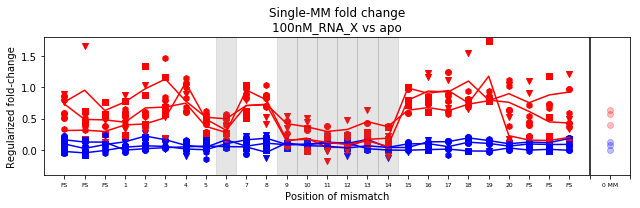

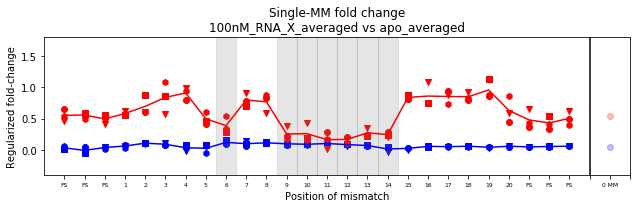

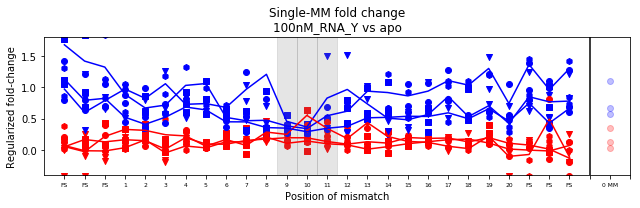

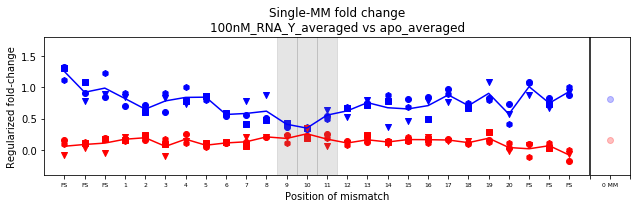

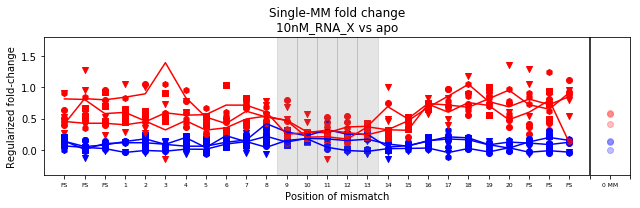

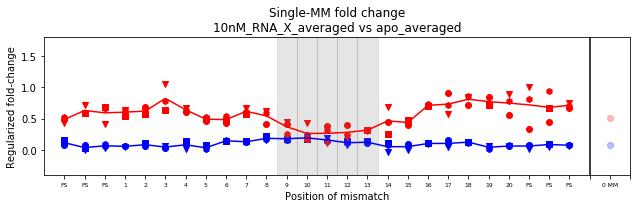

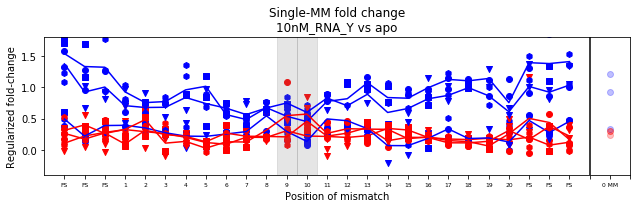

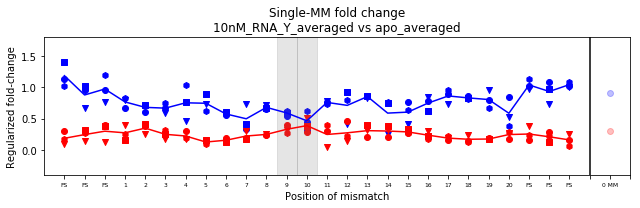

In [15]:
pvals = plot_single_mm('100nM_L4',  'apo')
_ = plot_single_mm('100nM_L4_averaged', 'apo_averaged', pvals = pvals)

pvals = plot_single_mm('100nM_L3', 'apo')
_ = plot_single_mm('100nM_L3_averaged', 'apo_averaged', pvals = pvals)

pvals = plot_single_mm('10nM_L4', 'apo')
_ = plot_single_mm('10nM_L4_averaged', 'apo_averaged', pvals = pvals)

pvals = plot_single_mm('10nM_L3', 'apo')
_ = plot_single_mm('10nM_L3_averaged', 'apo_averaged', pvals = pvals)

## 1D mismatch vs position plots, mismatch pairs
- Same as above
- Now using sequences with exactly 2 mismatches
- Each seq with 2 mismatches counts as a pair of half-sequences with 1 mismatch

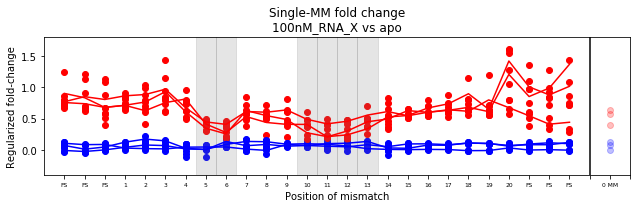

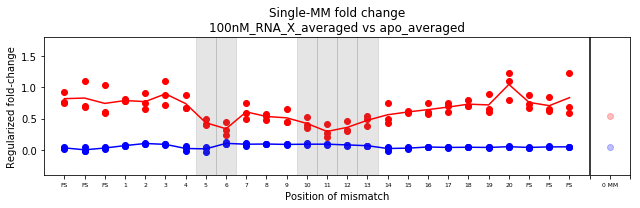

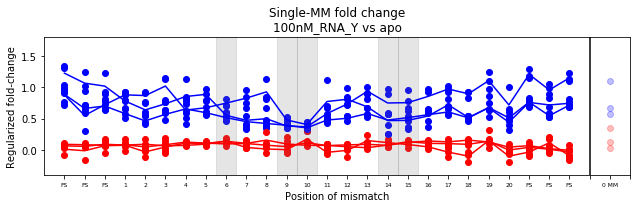

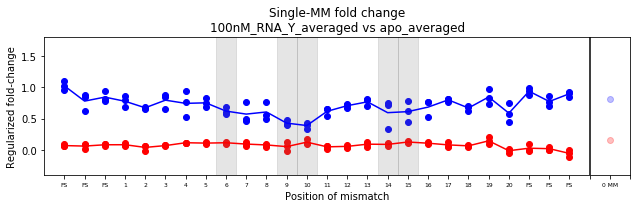

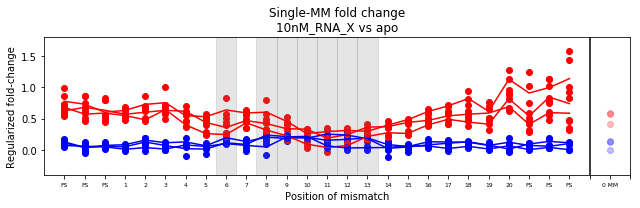

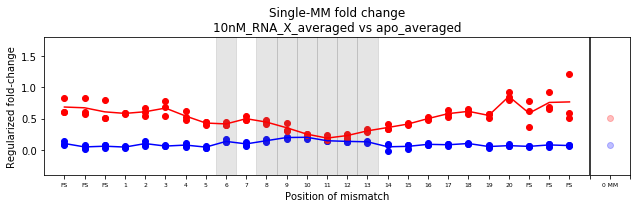

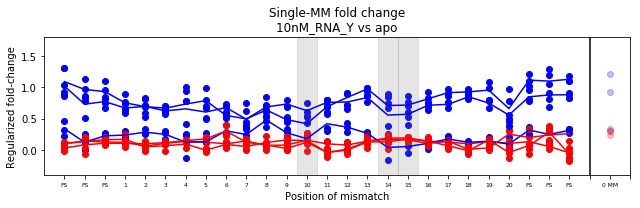

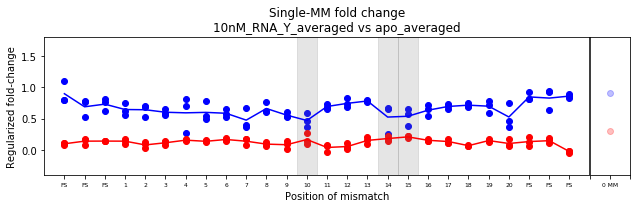

In [16]:
"""
single-mismatch plot for all kmers with 2 mismatches
    2-MM reads count as 2- half-reads
"""

pvals = plot_single_mm('100nM_L4',  'apo', key = 'pairs_all')
_ = plot_single_mm('100nM_L4_averaged', 'apo_averaged', pvals = pvals, key = 'pairs_all')

pvals = plot_single_mm('100nM_L3', 'apo', key = 'pairs_all')
_ = plot_single_mm('100nM_L3_averaged', 'apo_averaged', pvals = pvals, key = 'pairs_all')

pvals = plot_single_mm('10nM_L4', 'apo', key = 'pairs_all')
_ = plot_single_mm('10nM_L4_averaged', 'apo_averaged', pvals = pvals, key = 'pairs_all')

pvals = plot_single_mm('10nM_L3', 'apo', key = 'pairs_all')
_ = plot_single_mm('10nM_L3_averaged', 'apo_averaged', pvals = pvals, key = 'pairs_all')

## 2D heatmaps of paired mismatches

- Heat map
- Each pixel represents multiple sequences, all of which have exactly 2 mismatches at the same two sites (determied by its X / Y coordinates)
- Color is the average fold-change for those sequences
- Diagonal (X = Y) represents sequences with one mismatch, and is the data from the plots above

In [17]:
"""
pairwise hmap mm plot
"""
import matplotlib.patches as patches


def get_pair_mm_hmap(expt_id, ctrl_id, on = 'L3', delta_fc_flag = False):
    NUM_MM = 1    
    off = get_other_target(on)
    seq_len = len('AAAATAGCCGGGTGGTTCAGGCGGCG')
    WINDOW = seq_len
    
    expt_hmap = np.zeros((seq_len, seq_len))
    ctrl_hmap = np.zeros((seq_len, seq_len))
    
    offset = get_average_fc(expt_id, ctrl_id, off)
    rescale = get_average_fc(expt_id, ctrl_id, on)   
    
    single_mm_x, single_mm_y, _ = get_single_mm_data(expt_id, ctrl_id, on = on)    
    single_mm_y = [(i - offset) / rescale for i in single_mm_y]
    single_mm_y_averaged = {}
    
    for i, j in zip(single_mm_x, single_mm_y):
        if i not in single_mm_y_averaged:
            single_mm_y_averaged[i] = []
        single_mm_y_averaged[i].append(j)
    for key, val in single_mm_y_averaged.items():
        single_mm_y_averaged[key] = np.mean(val)
    
    
    nucs = ['A', 'G', 'C', 'T']
    nucs_to_idx = {key : i for i, key in enumerate(nucs)}
    target_filter = data.loc[data['ref_id'] == on].loc[data['num_mismatches'] == 2]
    
    for _, row in target_filter.iterrows():
        [x, y] = row['mismatch_lst']
        expt_hmap[x, y] += row[expt_id]
        expt_hmap[y, x] += row[expt_id]        
        
        ctrl_hmap[x, y] += row[ctrl_id]
        ctrl_hmap[y, x] += row[ctrl_id]
    
    #fc = ((expt_hmap / ctrl_hmap) - offset) / rescale
    fc = np.zeros((seq_len, seq_len))
    delta_fc = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(seq_len):
            fc[i,j] = ((expt_hmap[i,j] / ctrl_hmap[i,j]) - offset) / rescale
            #delta_fc[i,j] = (expt_hmap[i,j] / ctrl_hmap[i,j]) - (single_mm[i] * single_mm[j])
            
            if i == j:
                fc[i,j] = single_mm_y_averaged[i]
    
    if delta_fc_flag:
        return delta_fc
    else:
        return fc

def plot_hmap(expt_id, ctrl_id, delta_fc = False):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))
    
    on = expt_id.split('_')[1]
    off = (set(TARGETS) - set([on])).pop() 
    hmap = get_pair_mm_hmap(expt_id, ctrl_id, on = on, delta_fc_flag = delta_fc)
    
    vmin = -0.25
    vmax = 1.5
    if delta_fc:
        vmin = -1
        vmax = 1
    
    hmap = ax.imshow(
        hmap, cmap = 'jet', 
        interpolation = 'nearest', 
        aspect = 'auto', 
        origin = 'lower',
        vmin = vmin,
        vmax = vmax)
    
    for i in range(-1, 26):
        ax.add_patch(
            patches.Rectangle(
                (i - 0.5, i - 0.5),   # (x,y)
                1,          # width
                1,          # height
                fill = False,
                color = 'white',
                linewidth = 2
            ))
    
    cbar = plt.colorbar(hmap, orientation='vertical')
    wt = normalize_datapoint(
        get_wt_fc(expt_id, ctrl_id, on), 
        get_average_fc(expt_id, ctrl_id, off), 
        get_average_fc(expt_id, ctrl_id, on))
    
    cbar.ax.plot([0, 1], [wt] * 2, 'k', linewidth = 2, ls = '-')
    #cb.ax.plot([0, 1], [rms]*2, 'w')

    ax.set_xlim([-1, 26])
    ax.set_ylim([-1, 26])

    ax.set_xticks(list(range(26)))
    ax.set_yticks(list(range(26)))
    
    ticklabels = ['FS', 'FS', 'FS'] + \
        [i for i in (range(1, 21))] + \
        ['FS', 'FS', 'FS']
    ax.set_xticklabels(ticklabels, fontsize = 6)
    ax.set_yticklabels(ticklabels, fontsize = 6)
    
    ax.set_xlabel('Position of mismatch')
    ax.set_ylabel('Position of mismatch')
    ax.set_title('Paired mismatch regularized fold changes\n%s vs %s ' % (update_label(expt_id), update_label(ctrl_id)))
    
    #fig.savefig('./plots/pair_MM_hmap__%s_vs_%s.pdf' % (update_label(expt_id), update_label(ctrl_id)))

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


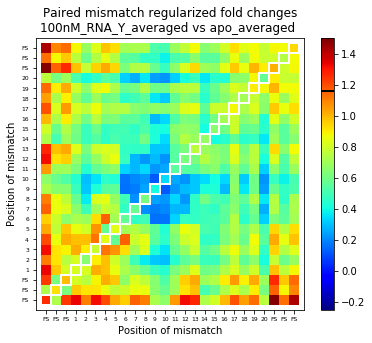

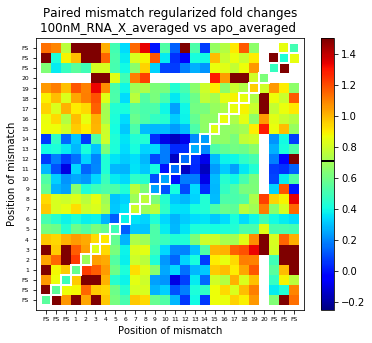

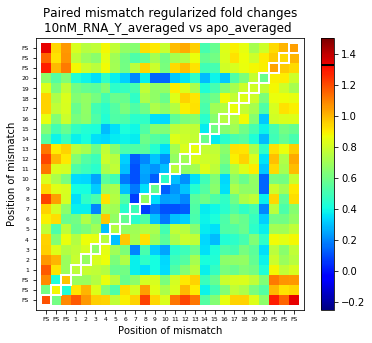

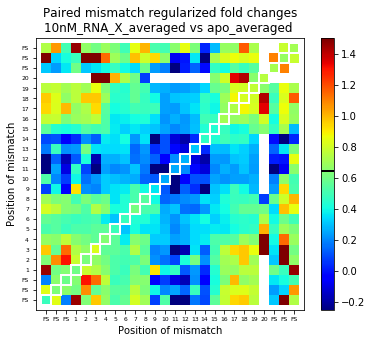

In [18]:
plot_hmap('100nM_L3_averaged', 'apo_averaged', delta_fc = False)
plot_hmap('100nM_L4_averaged', 'apo_averaged', delta_fc = False)
plot_hmap('10nM_L3_averaged', 'apo_averaged', delta_fc = False)
plot_hmap('10nM_L4_averaged', 'apo_averaged', delta_fc = False)